In [13]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import numpy as np
import math

In [30]:
np.random.seed(42)
a = np.array([12345678910]).astype(np.float64)

a_gpu = cuda.mem_alloc(4*2)

cuda.memcpy_htod(a_gpu, a)

print(a)

[1.23456789e+10]


In [31]:
np.random.seed(42)
a = np.array([12345678910]).astype(np.float32)

a_gpu = cuda.mem_alloc(4*1)

cuda.memcpy_htod(a_gpu, a)

print(a)

[1.2345679e+10]


In [29]:
a_out = np.empty_like(a)

cuda.memcpy_dtoh(a_out, a_gpu)

print(a_out)

[1.2345679e+10]


# Module

In [3]:
class MinimumEnergyControl:
    def __init__(self, x_des, x_0, step=50, dt=0.05):

        ## very important constants
        self.byte = 4
        self.axis = 3
        self.DOF  = 6
        self.step = step

        ## gravity, criterion: moon
        gravity = 1.62      # N/kg

        ## A
        state_transition_matrix = \
        np.array([[ 1, 0, 0,dt, 0, 0],
                  [ 0, 1, 0, 0,dt, 0],
                  [ 0, 0, 1, 0, 0,dt],
                  [ 0, 0, 0, 1, 0, 0],
                  [ 0, 0, 0, 0, 1, 0],
                  [ 0, 0, 0, 0, 0, 1]])

        ## B
        input_matrix = \
        np.array([[0.5*dt*dt,        0,        0],
                  [        0,0.5*dt*dt,        0],
                  [        0,        0,0.5*dt*dt],
                  [        dt,       0,        0],
                  [        0,        dt,       0],
                  [        0,        0,       dt]])
        self.input_matrix = cuda.mem_alloc(self.byte*2)
        cuda.memcpy_htod(self.input_matrix, input_matrix[::3,0].astype(np.float32))

        ## g
        gravity_matrix = \
        np.array([[                0],
                  [                0],
                  [0.5*gravity*dt*dt],
                  [                0],
                  [                0],
                  [       gravity*dt]]) 
        self.gravity_matrix = cuda.mem_alloc(self.byte*2)
        cuda.memcpy_htod(self.gravity_matrix, gravity_matrix[2::3].astype(np.float32))

        ## desired state: x_des
        self.x_des = cuda.mem_alloc(self.byte*self.DOF)
        cuda.memcpy_htod(self.x_des, x_des.astype(np.float32))

        ## initial state: x_0
        self.x_0 = cuda.mem_alloc(self.byte*self.DOF)
        cuda.memcpy_htod(self.x_0, x_0.astype(np.float32))

        ## current state: x_current
        self.x_current = cuda.mem_alloc(self.byte*self.DOF)
        cuda.memcpy_htod(self.x_current, x_0.astype(np.float32))
        
        ## dt
        self.dt = np.float32(dt)

        ## weight
        self.rho = 1

        ## define kernel function
        self.kernel_function()

    def run(self):
        ## get_gradient
        self.get_gradient(self.gram_G,
                          self.u,
                          self.G_C,
                          self.iteration,
                          self.gradient,
                          np.int32(self.step),
                          block=(self.TPB,1,1),
                          grid=(self.axis*self.step,1,1))

    def define_problem(self):
        ## initialize
        try:
            self.memory_free()
        except:
            pass

        ## TPB, iteration
        self.TPB, self.iteration = self.define_optimal_kernel_size()

        ## matrices
        self.memory_allocation()
        self.define_matrix()

    def define_optimal_kernel_size(self):
        thread_per_block = int(math.sqrt(self.step/2))
        
        iteration = int(self.step / thread_per_block) + 1

        return thread_per_block, np.int32(iteration)

    def memory_allocation(self):
        ## rho matrix: 36 * step * step bytes
        rho_matrix = (math.sqrt(self.rho) * np.identity(self.axis*self.step)).astype(np.float32)
        rho_matrix_byte = self.byte * self.axis * self.axis * self.step * self.step
        self.rho_matrix = cuda.mem_alloc(rho_matrix_byte)
        cuda.memcpy_htod(self.rho_matrix, rho_matrix)

        ## solution!!!
        u = np.zeros((self.axis*self.step)).astype(np.float32)
        u_byte = self.byte * self.axis * self.step
        self.u = cuda.mem_alloc(u_byte)
        cuda.memcpy_htod(self.u, u)

        ## G
        G = np.zeros((self.DOF*self.axis*self.step)).astype(np.float32)
        G_byte = self.byte * self.DOF * self.axis * self.step
        self.G = cuda.mem_alloc(G_byte)
        cuda.memcpy_htod(self.G, G)

        ## gram_G
        gram_G = np.zeros((self.axis*self.axis*self.step*self.step)).astype(np.float32)
        gram_G_byte = self.byte * self.axis * self.axis * self.step * self.step
        self.gram_G = cuda.mem_alloc(gram_G_byte)
        cuda.memcpy_htod(self.gram_G, gram_G)

        ## Q
        Q = np.zeros((self.DOF)).astype(np.float32)
        Q_byte = self.byte * self.DOF
        self.Q = cuda.mem_alloc(Q_byte)
        cuda.memcpy_htod(self.Q, Q)

        ## C
        C = np.zeros((self.DOF)).astype(np.float32)
        C_byte = self.byte * self.DOF
        self.C = cuda.mem_alloc(C_byte)
        cuda.memcpy_htod(self.C, C)

        ## G_C
        G_C = np.zeros((self.axis*self.step)).astype(np.float32)
        G_C_byte = self.byte * self.axis * self.step
        self.G_C = cuda.mem_alloc(G_C_byte)
        cuda.memcpy_htod(self.G_C, G_C)

        ## gradient
        gradient = np.zeros((self.axis*self.step)).astype(np.float32)
        gradient_byte = self.byte * self.axis * self.step
        self.gradient = cuda.mem_alloc(gradient_byte)
        cuda.memcpy_htod(self.gradient, gradient)

    def define_matrix(self):
        self.get_G_matrix(self.input_matrix,
                          self.dt,
                          self.G,
                          block=(6,1,1),
                          grid=(self.step,1,1))
        
        self.get_Q_matrix(self.gravity_matrix,
                          self.dt,
                          self.Q,
                          block=(self.step,1,1),
                          grid=(2,1,1))
        
        self.get_G_gram_matrix(self.G,
                               self.rho_matrix,
                               self.gram_G,
                               np.int32(self.step),
                               block=(3,1,1),
                               grid=(self.step,self.step,1))
                               
        self.get_G_C_matrix(self.G,
                            self.x_des,
                            self.x_0,
                            self.Q,
                            self.C,
                            self.G_C,
                            block=(3,1,1),
                            grid=(self.step,1,1))

    def memory_free(self):
        self.rho_matrix.free()
        self.u.free()
        self.G.free()
        self.gram_G.free()
        self.Q.free()
        self.C.free()
        self.G_C.free()
        self.gradient.free()

    def memory_freeall(self):

        try:
            self.memory_free()
        except:
            pass

        self.input_matrix.free()
        self.gravity_matrix.free()
        self.x_des.free()
        self.x_0.free()
        self.x_current.free()

    def kernel_function(self):
        ## block=(TPB,1,1), grid=(axis*step,1,1)
        get_gradient_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)
        #define gs (gridDim.x)

        __global__ void get_gradient(float* matrix, float* vector1, float* vector2, int iteration, float* result, int step) {

            __shared__ float result_jerk[1000];

            result_jerk[tx] = 0.0;

            for (int i = 0; i < iteration; i++) {            
                int index1 = i + tx * iteration;
                int index2 = index1 + bx * 3 * step;

                if (index1 < gs) {
                    result_jerk[tx] += matrix[index2] * vector1[index1];
                }
                else {
                    result_jerk[1000-tx] = 0.0;
                }
            }

            __syncthreads();

            if (tx == 0) {
                for (int j = 0; j < bs; j++) {
                    result[bx] += result_jerk[j];
                }

                result[bx] -= vector2[bx];
            }
            else {
                result_jerk[1000-tx] = 0.0;
            }

            __syncthreads();
        }
        """
        get_gradient_ker = SourceModule(get_gradient_ker_function)

        ## block=(6,1,1), grid=(step,1,1)
        get_G_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define step (gridDim.x)

        __global__ void get_G_matrix(float* input_matrix, float dt, float* G) {
            // 6: DOF, 18: axis * DOF
            int index = tx + (tx%3) * 6 + bx * 18;

            if (tx < 3) {
                float value;
                value = input_matrix[0] + (step - bx - 1) * dt * input_matrix[1];

                G[index] = value;
            }
            else {
                G[index] = dt;
            }

            __syncthreads();
        }
        """
        get_G_matrix_ker = SourceModule(get_G_matrix_ker_function)

        ## block=(step,1,1), grid=(2,1,1)
        get_Q_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define step (blockDim.x)

        __global__ void get_Q_matrix(float* gravity, float dt, float* Q) {
            
            __shared__ float value[1000];

            if (bx == 0) {
                value[tx] = gravity[0] + (tx * dt) * gravity[1];
            }
            else {
                value[tx] = gravity[1];
            }

            __syncthreads();

            if (bx == 0) {
                if (tx == 0) {
                    for (int i = 0; i < step; i++) {
                        Q[2] += value[i];
                    }
                }
            }
            else {
                if (tx == 0) {
                    for (int i = 0; i < step; i++) {
                        Q[5] += value[i];
                    }
                }
            }

            __syncthreads();
        }
        """
        get_Q_matrix_ker = SourceModule(get_Q_matrix_ker_function)

        ## block=(3,1,1), grid=(step,step,1)
        get_G_gram_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define by (blockIdx.y)
        #define step (gridDim.x)

        __global__ void get_G_gram_matrix(float* G, float* rho_matrix, float* gram_G) {
            // 3: axis
            int index1 = 3 * step + 1;
            int index2 = 3 * 3 * step;
            int index3 = tx * index1 + bx * 3 + by * index2;

            // 7: DOF+1, 18: axis*DOF
            int index4 = tx * 7 + bx * 18;
            int index5 = tx * 7 + by * 18;

            float value = 0.0;
            value = G[index4] * G[index5] + G[index4+3] * G[index5+3];

            gram_G[index3] = value;

            __syncthreads();

            gram_G[index3] += rho_matrix[index3] * rho_matrix[index3];

            __syncthreads();
        }
        """
        get_G_gram_matrix_ker = SourceModule(get_G_gram_matrix_ker_function)

        ## block=(3,1,1), grid=(step,1,1)
        get_G_C_matrix_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)

        __global__ void get_G_C_matrix(float* G, float* x_des, float* x_current, float* Q, float* C, float * G_C) {

            __shared__ float C_jerk[6];

            C_jerk[tx] = x_des[tx] - Q[tx] - x_current[tx];
            C_jerk[tx+3] = x_des[tx+3] - Q[tx+3] - x_current[tx+3];

            __syncthreads();

            C[tx] = C_jerk[tx];
            C[tx+3] = C_jerk[tx+3];


            __syncthreads();

            // 7: DOF+1, 18: axis*DOF;
            int index1 = tx * 7 + bx * 18;
            int index2 = tx + bx * 3;

            float value;
            value = G[index1] * C_jerk[tx] + G[index1+3] * C_jerk[tx+3];

            __syncthreads();

            G_C[index2] = value;

            __syncthreads();
        }
        """
        get_G_C_matrix_ker = SourceModule(get_G_C_matrix_ker_function)

        self.get_G_matrix      = get_G_matrix_ker.get_function("get_G_matrix")
        self.get_Q_matrix      = get_Q_matrix_ker.get_function("get_Q_matrix")
        self.get_G_gram_matrix = get_G_gram_matrix_ker.get_function("get_G_gram_matrix")
        self.get_G_C_matrix    = get_G_C_matrix_ker.get_function("get_G_C_matrix")
        self.get_gradient      = get_gradient_ker.get_function("get_gradient")

    def copy_and_unpack_result(self):
        ## copy rho matrix
        rho_matrix = np.empty((self.axis*self.axis*self.step*self.step)).astype(np.float32)
        cuda.memcpy_dtoh(rho_matrix, self.rho_matrix)

        ## copy solution
        u = np.empty((self.axis*self.step)).astype(np.float32)
        cuda.memcpy_dtoh(u, self.u)

        ## copy G matrix        
        G = np.empty((self.DOF*self.axis*self.step)).astype(np.float32)
        cuda.memcpy_dtoh(G, self.G)

        ## copy gram matrix of G
        gram_G = np.empty((self.axis*self.axis*self.step*self.step)).astype(np.float32)
        cuda.memcpy_dtoh(gram_G, self.gram_G)

        ## copy Q matrix
        Q = np.empty((self.DOF)).astype(np.float32)
        cuda.memcpy_dtoh(Q, self.Q)

        ## copy C matrix
        C = np.empty((self.DOF)).astype(np.float32)
        cuda.memcpy_dtoh(C, self.C)

        ## copy G_C matrix
        G_C = np.empty((self.axis*self.step)).astype(np.float32)
        cuda.memcpy_dtoh(G_C, self.G_C)

        ## pack data
        matrices = dict()
        matrices["rho_matrix"] = rho_matrix.reshape(self.axis*self.step,self.axis*self.step)
        matrices["u"]          = u.reshape(self.axis*self.step,1)
        matrices["G"]          = G.reshape(self.axis*self.step,self.DOF).T 
        matrices["gram_G"]     = gram_G.reshape(self.axis*self.step,self.axis*self.step) 
        matrices["Q"]          = Q.reshape(self.DOF,1)
        matrices["C"]          = C.reshape(self.DOF,1)
        matrices["G_C"]        = G_C.reshape(self.axis*self.step,1)

        ## delete all memory
        self.memory_free()

        return matrices

In [4]:
class OptimizerForGuidance:
    def __init__(self, learning_rate):
        ## set parameters
        self.learning_rate = np.float32(learning_rate)
        
        ## kernel function
        self.kernel_function()

    def run(self, theta, gradient, step):
        ## theta, gradient: gpuarray type variable
        self.basic_optimizer(theta,
                             gradient,
                             self.learning_rate,
                             block=(3,1,1),
                             grid=(step,1,1))

    def kernel_function(self):
        ## block=(3,1,1), grid=(step,1,1)
        basic_optimizer_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)

        __global__ void basic_optimizer(float* theta, float* gradient, float learning_rate) {
            int index = tx + bx * 3;

            theta[index] -= gradient[index] * learning_rate;

            __syncthreads();
        }
        """
        basic_optimizer_ker = SourceModule(basic_optimizer_ker_function)

        self.basic_optimizer = basic_optimizer_ker.get_function("basic_optimizer")

In [5]:
class ConstraintsForInput:
    def __init__(self, problem, upper_boundary, downer_boundary):
        ## ex> MEC(minimum energy control)
        self.problem = problem

        self.upper_boundary = np.float32(upper_boundary)
        self.downer_boundary = np.float32(downer_boundary)

        ## kernel function
        self.kernel_function()

    def projection(self):
        self.project_function(self.problem.u,
                              self.upper_boundary,
                              self.downer_boundary,
                              block=(3,1,1),
                              grid=(self.problem.step,1,1))

    def kernel_function(self):
        ##block=(3,1,1), grid=(step,1,1)
        projection_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)

        __device__ float square_root(float value) {
            float s = 0;
            float t = 0;

            s = value / 2;

            for (;s != t;) {
                t = s;
                s = ((value/t) + t) / 2;
            }

            return s;
        }

        __device__ float get_norm(float* vector, int length) {
            float value = 0.0;
            float norm;

            for (int i = 0; i < length; i++) {
                value += vector[i] * vector[i];
            }

            norm = square_root(value);

            return norm;
        }

        __global__ void projection(float* theta, float upper_boundary, float downer_boundary) {

            __shared__ float u[3];
            __shared__ float norm[1];
            __shared__ float value[3];

            int index = tx + bx * 3;

            u[tx] = theta[index];

            __syncthreads();

            if (tx == 0) {
                norm[0] = get_norm(u, 3);
            }

            __syncthreads();

            if ((norm[0] > downer_boundary) && (norm[0] < upper_boundary)) {
                value[tx] = u[tx];
            }
            else {
                value[tx] = u[tx] * upper_boundary / norm[0];
            }

            __syncthreads();

            theta[index] = value[tx];
        }
        """
        projection_ker = SourceModule(projection_ker_function)

        self.project_function = projection_ker.get_function("projection")

# Last One... MECS class

In [5]:
class MinimumEnergyControlSolver:
    def __init__(self, x_des, x_0, upper_boundary, downer_boundary, step=50, max_iteration=200):
        ## important constants
        self.byte = 4
        self.axis = 3
        self.DOF  = 6
        self.step = step
        self.initial_step = step

        ## max iteration
        self.max_iteration = max_iteration

        ## initialize MEC(minimum energy control)
        self.MEC = MinimumEnergyControl(x_des, x_0, step=step)

        ## initialize optimizer
        learning_rate = 1e-4

        self.optimizer = OptimizerForGuidance(learning_rate)

        ## constraint
        self.upper_boundary  = upper_boundary
        self.downer_boundary = downer_boundary

        self.constraint = ConstraintsForInput(self.MEC, self.upper_boundary, self.downer_boundary)

        ## evaluate
        ## error_vector
        error_vector_byte = self.byte * (self.DOF + self.axis*self.step)
        self.error_vector = cuda.mem_alloc(error_vector_byte)

        ## error
        error = np.zeros((self.initial_step)).astype(np.float32)
        error_byte = self.byte * self.initial_step
        self.error = cuda.mem_alloc(error_byte)
        cuda.memcpy_htod(self.error, error)

        ## state record
        state = np.zeros((self.DOF*self.step)).astype(np.float32)
        state_byte = self.byte * self.DOF * self.step
        self.state = cuda.mem_alloc(state_byte)
        cuda.memcpy_htod(self.state, state)

        ## kernel function
        self.kernel_function()

    def solve(self):
    # for step in range(self.MEC.step-1):
        ## define problem: fit matrices for left step
        self.MEC.define_problem()

        for iteration in range(self.max_iteration):
            ## get gradient
            self.MEC.run()

            ## optimize
            self.optimizer.run(self.MEC.u, self.MEC.gradient, self.MEC.step)

            ## constraint
            self.constraint.projection()
        
        ## evaluate
        self.evaluate(0)

        ## update state
        self.update_state(0)

        ## record data

        ## next step
        self.MEC.step -= 1
    
    def define_optimal_kernel_size(self):
        thread_per_block = int(math.sqrt(self.step/2))
        
        iteration = int(self.step / thread_per_block) + 1

        return thread_per_block, np.int32(iteration)

    def evaluate(self, current_step):
        ## set size
        block_size = self.step + 2
        grid_size  = self.axis * self.step + self.DOF

        ## evaluate learning
        self.get_error_vector(self.MEC.G,
                              self.MEC.rho_matrix,
                              self.MEC.u,
                              self.MEC.C,
                              self.MEC.iteration,
                              self.error_vector,
                              block=(self.MEC.TPB,1,1),
                              grid=(grid_size,1,1))
        
        self.get_error(self.error_vector,
                       self.error,
                       np.int32(current_step),
                       block=(block_size,1,1),
                       grid=(1,1,1))

    def update_state(self, step):
        ## update state
        self.get_next_state(self.MEC.x_current,
                            self.MEC.u,
                            self.MEC.dt,
                            self.MEC.gravity_matrix,
                            self.state,
                            np.int32(step),
                            block=(6,1,1),
                            grid=(1,1,1))

    def memory_freeall(self):

        try:
            self.MEC.memory_freeall()

        except:
            pass

        self.error_vector.free()
        self.error.free()
        self.state.free()

    def kernel_function(self):
        ## block=(TPB,1,1), grid=(DOF+axis*step,1,1)
        get_error_vector_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)
        #define gs (gridDim.x)

        __global__ void get_error_vector(float* G, float* rho_matrix, float* u, float* C, int iteration, float* error_vector) {

            if (bx < 6) {

                __shared__ float value[100];

                value[tx] = 0.0;

                __syncthreads();

                for (int i = 0; i < iteration; i++) {
                    int index1 = bx % 3;
                    int index2 = i * 5 + tx % 5;
                    int index3 = index1 + index2 * 3;
                    int index4 = bx + index1 * 6 + index2 * 18;

                    value[tx] += G[index4] * u[index3];
                }

                __syncthreads();

                if (tx == 0) {
                    value[50] = 0.0;

                    for (int j = 0; j < bs; j++) {
                        value[50] += value[j];
                    }

                    error_vector[bx] = value[50] - C[bx];
                }

                __syncthreads();
            }
            else {
                if (tx == 0) {
                    int index1 = bx - 6;
                    int index2 = gs - 5;
                    int index3 = index1 * index2;

                    error_vector[bx] = rho_matrix[index3] * u[index1];
                }

                __syncthreads();
            }
        }
        """
        get_error_vector_ker = SourceModule(get_error_vector_ker_function)

        ## block=(step+2,1,1), grid=(1,1,1)
        get_error_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)

        __device__ float square_root(float value) {
            float s = 0;
            float t = 0;

            s = value / 2;

            for (;s != t;) {
                t = s;
                s = ((value/t) + t) / 2;
            }

            return s;
        }

        __device__ float get_norm(float* vector, int length) {
            float value = 0.0;
            float norm;

            for (int i = 0; i < length; i++) {
                value += vector[i] * vector[i];
            }

            norm = square_root(value);

            return norm;
        }

        __global__ void get_error(float* error_vector, float* error, int current_step) {

            __shared__ float value[1000];

            int index = tx * 3;

            for (int i = 0; i < 3; i++) {
                value[index+i] = error_vector[index+i];
            }

            __syncthreads();

            if (tx == 0) {
                int length = bs;

                error[current_step] = get_norm(value, length);
            }

            __syncthreads();
        }
        """
        get_error_ker = SourceModule(get_error_ker_function)

        ## block=(6,1,1), grid=(1,1,1)
        get_next_state_ker_function = \
        """
        #define tx (threadIdx.x)

        __global__ void get_next_state(float* x, float* u, float dt, float* gravity_matrix, float* state, int step) {

            __shared__ float momentum[6];
            __shared__ float input[6];
            __shared__ float gravity[6];

            int index1 = tx + step * 6;

            if (tx < 3) {
                int index2 = tx % 3;

                momentum[tx] = x[tx] + dt * x[tx+3];
                input[tx]    = 0.5*dt*dt * u[index2];

                if (index2 == 2) {
                    gravity[tx] = gravity_matrix[tx];
                }
                else {
                    gravity[tx] = 0.0;
                }
            }
            else {
                int index2 = tx % 3;

                momentum[tx] = x[tx];
                input[tx]    = dt * u[index2];

                if (index2 == 2) {
                    gravity[tx] = gravity_matrix[tx];
                }
                else {
                    gravity[tx] = 0.0;
                }
            }

            __syncthreads();

            x[tx] = momentum[tx] + input[tx] + gravity[tx];
            state[index1] = x[tx];

            __syncthreads();
        }
        """
        get_next_state_ker = SourceModule(get_next_state_ker_function)

        self.get_error_vector = get_error_vector_ker.get_function("get_error_vector")
        self.get_error        = get_error_ker.get_function("get_error")
        self.get_next_state   = get_next_state_ker.get_function("get_next_state")

    def copy_and_unpack_result(self):
        
        ## unpack matrix
        try:
            matrices = self.MEC.copy_and_unpack_result()
        except:
            pass

        ## copy state
        state = np.empty((self.DOF*self.initial_step)).astype(np.float32)
        cuda.memcpy_dtoh(state, self.state)

        ## copy error
        error = np.empty((self.initial_step)).astype(np.float32)
        cuda.memcpy_dtoh(error, self.error)

        ## pack data
        matrices["state"] = state.reshape(self.initial_step,self.DOF).T
        matrices["error"] = error.reshape(self.initial_step)

        ## delete all memory
        self.memory_freeall()

        return matrices

# Test

In [ ]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([100,0,-1500,1-10,0,80])

upper_boundary = 5.8
downer_boundary = 0.0

MECS = MinimumEnergyControlSolver(x_des, x_0, upper_boundary, downer_boundary, step=300)

In [ ]:
cuda.mem_get_info()

(15734669312, 15843721216)

In [ ]:
MECS.solve()

In [ ]:
cuda.mem_get_info()

(15726280704, 15843721216)

In [ ]:
result = MECS.copy_and_unpack_result()

In [ ]:
cuda.mem_get_info()

(15736766464, 15843721216)

In [ ]:
result["state"]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
result["error"]

array([1373.9573,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
          0.    ,    0.    ,    0.    ,    0.    , 

# Test2

In [ ]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([100,0,-1500,-10,0,80])

upper_boundary = 5.8
downer_boundary = 0.0

MEC = MinimumEnergyControl(x_des, x_0, step=300)

MECS = MinimumEnergyControlSolver(MEC, x_des, x_0, upper_boundary, downer_boundary, step=300)

In [ ]:
MECS.solve()

In [ ]:
cuda.mem_get_info()

(15726280704, 15843721216)

In [ ]:
result1 = MEC.copy_and_unpack_result()

In [ ]:
result2 = MECS.copy_and_unpack_result()

In [ ]:
result1["u"]

(300, 1)

In [ ]:
result1["rho_matrix"]

(300, 300)

In [ ]:
MEC = MinimumEnergyControl(x_des, x_0, step=300)

In [ ]:
x_current = np.empty((6)).astype(np.float32)
cuda.memcpy_dtoh(x_current, MEC.x_current)
x_current

array([  100.,     0., -1500.,    -9.,     0.,    80.], dtype=float32)

In [ ]:
MEC.define_problem()

In [ ]:
MEC.run()

In [ ]:
gradient = np.empty((3*300)).astype(np.float32)
cuda.memcpy_dtoh(gradient, MEC.gradient)
gradient.T[:6]

array([  56.75863 ,    0.      , -748.35406 ,   56.563946,    0.      ,
       -745.78955 ], dtype=float32)

In [ ]:
result = MEC.copy_and_unpack_result()

In [ ]:
MEC.memory_freeall()

# Test 3

In [ ]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([100,0,-1500,-10,0,80])

upper_boundary = 5.8
downer_boundary = 0.0

MECS = MinimumEnergyControlSolver(x_des, x_0, upper_boundary, downer_boundary, step=300)

In [ ]:
MECS.solve()

[-74.375     0.      981.4504  -74.125     0.      978.156   -73.875
   0.      974.86163 -73.625     0.      971.56726]
[-74.375     0.      981.4504  -74.125     0.      978.156   -73.875
   0.      974.86163 -73.625     0.      971.56726]


In [ ]:
result = MECS.copy_and_unpack_result()

In [ ]:
result["state"][:,:2]

array([[ 9.9499710e+01,  0.0000000e+00],
       [-2.9088272e-04,  0.0000000e+00],
       [-1.4960002e+03,  0.0000000e+00],
       [-1.0011636e+01,  0.0000000e+00],
       [-1.1635308e-02,  0.0000000e+00],
       [ 7.9988365e+01,  0.0000000e+00]], dtype=float32)

In [ ]:
result["error"][:6]

array([1378.031,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ],
      dtype=float32)

In [ ]:
result["G"][:,:3]

array([[0.74875003, 0.        , 0.        ],
       [0.        , 0.74875003, 0.        ],
       [0.        , 0.        , 0.74875003],
       [0.05      , 0.        , 0.        ],
       [0.        , 0.05      , 0.        ],
       [0.        , 0.        , 0.05      ]], dtype=float32)

In [ ]:
result["u"][:12]

array([[-0.23270616],
       [-0.23270616],
       [-0.23270616],
       [-0.23240001],
       [-0.23240001],
       [-0.23240001],
       [-0.23208891],
       [-0.23208891],
       [-0.23208891],
       [-0.23177199],
       [-0.23177199],
       [-0.23177199]], dtype=float32)

In [ ]:
result["gram_G"]

(897, 897)

In [ ]:
MEC = MinimumEnergyControl(x_des, x_0, step=300)

In [ ]:
MEC.define_problem()

In [ ]:
MEC.run()

In [ ]:
gradient = np.empty((900)).astype(np.float32)
cuda.memcpy_dtoh(gradient, MEC.gradient)
gradient[:12]

array([  74.375  ,    0.     , -981.4504 ,   74.125  ,    0.     ,
       -978.156  ,   73.875  ,    0.     , -974.86163,   73.625  ,
          0.     , -971.56726], dtype=float32)

In [ ]:
optimizer = OptimizerForGuidance(1e-4)
optimizer.run(MEC.u, MEC.gradient, 300)

In [ ]:
u = np.empty((900)).astype(np.float32)
cuda.memcpy_dtoh(u, MEC.u)
u[:12]

array([-0.0074375 ,  0.        ,  0.09814504, -0.0074125 ,  0.        ,
        0.0978156 , -0.0073875 ,  0.        ,  0.09748616, -0.0073625 ,
        0.        ,  0.09715673], dtype=float32)

In [ ]:
MEC.run()

In [ ]:
optimizer.run(MEC.u, MEC.gradient, 300)

In [ ]:
u = np.empty((900)).astype(np.float32)
cuda.memcpy_dtoh(u, MEC.u)
u[:12]

array([-0.02220783,  0.        ,  0.29305384, -0.02213318,  0.        ,
        0.29207015, -0.02205854,  0.        ,  0.29108647, -0.02198388,
        0.        ,  0.29010278], dtype=float32)

In [ ]:
constraint = ConstraintsForInput(MEC, 5.8, 0.0)
constraint.projection()

In [ ]:
u = np.empty((900)).astype(np.float32)
cuda.memcpy_dtoh(u, MEC.u)
u[:12]

array([-0.02220783, -0.02220783, -0.02220783, -0.02213318, -0.02213318,
       -0.02213318, -0.02205854, -0.02205854, -0.02205854, -0.02198388,
       -0.02198388, -0.02198388], dtype=float32)

# Test 4

In [6]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([100,0,-1500,-10,0,80])

MEC = MinimumEnergyControl(x_des, x_0, step=300)

In [7]:
MEC.define_problem()

In [8]:
MEC.run()

In [9]:
optimizer = OptimizerForGuidance(1e-4)
optimizer.run(MEC.u, MEC.gradient, 300)

In [10]:
constraint = ConstraintsForInput(MEC, 5.8, 0.0)
constraint.projection()

In [11]:
u = np.empty((900)).astype(np.float32)
cuda.memcpy_dtoh(u, MEC.u)
u[:12]

array([-0.0074375 ,  0.        ,  0.09814504, -0.0074125 ,  0.        ,
        0.0978156 , -0.0073875 ,  0.        ,  0.09748616, -0.0073625 ,
        0.        ,  0.09715673], dtype=float32)

In [12]:
for i in range(200):
    MEC.run()

    optimizer.run(MEC.u, MEC.gradient, 300)

    constraint.projection()

u = np.empty((900)).astype(np.float32)
cuda.memcpy_dtoh(u, MEC.u)
u.T

array([-0.4383191 ,  0.        ,  5.783414  , -0.43831828,  0.        ,
        5.7834144 , -0.43831256,  0.        ,  5.7834144 , -0.43830884,
        0.        ,  5.783415  , -0.43830928,  0.        ,  5.7834144 ,
       -0.43830767,  0.        ,  5.7834153 , -0.43829915,  0.        ,
        5.7834153 , -0.43829533,  0.        ,  5.7834163 , -0.43830028,
        0.        ,  5.7834153 , -0.438298  ,  0.        ,  5.7834153 ,
       -0.43829095,  0.        ,  5.7834163 , -0.43828788,  0.        ,
        5.7834167 , -0.4382888 ,  0.        ,  5.7834163 , -0.43828312,
        0.        ,  5.7834167 , -0.43827838,  0.        ,  5.783417  ,
       -0.43828002,  0.        ,  5.783417  , -0.4382769 ,  0.        ,
        5.783417  , -0.43826866,  0.        ,  5.7834177 , -0.43826315,
        0.        ,  5.783418  , -0.43826225,  0.        ,  5.7834187 ,
       -0.43825808,  0.        ,  5.7834187 , -0.4382563 ,  0.        ,
        5.783419  , -0.4382444 ,  0.        ,  5.7834196 , -0.43

In [20]:
cuda.mem_get_info()

(15726280704, 15843721216)

In [21]:
MEC.memory_freeall()

In [22]:
cuda.mem_get_info()

(15736766464, 15843721216)

# GOGO!!!!!!!!!!

In [6]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([100,0,-1500,-10,0,80])

upper_boundary = 5.8
downer_boundary = 0.0

MECS = MinimumEnergyControlSolver(x_des, x_0, upper_boundary, downer_boundary, step=300)

In [7]:
MECS.solve()

In [8]:
result = MECS.copy_and_unpack_result()

In [9]:
result["state"][:,:2]

array([[   99.49945 ,     0.      ],
       [    0.      ,     0.      ],
       [-1495.9928  ,     0.      ],
       [  -10.021916,     0.      ],
       [    0.      ,     0.      ],
       [   80.28917 ,     0.      ]], dtype=float32)

In [10]:
result["error"][:6]

array([656.4978,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
      dtype=float32)

In [11]:
result["u"][:12]

array([[-0.43831998],
       [ 0.        ],
       [ 5.783414  ],
       [-0.43831655],
       [ 0.        ],
       [ 5.7834144 ],
       [-0.43831402],
       [ 0.        ],
       [ 5.783415  ],
       [-0.43831205],
       [ 0.        ],
       [ 5.7834144 ]], dtype=float32)

# EYES!

In [39]:
class MinimumEnergyControlSolver:
    def __init__(self, x_des, x_0, upper_boundary, downer_boundary, step=50, max_iteration=200):
        ## important constants
        self.byte = 4
        self.axis = 3
        self.DOF  = 6
        self.step = step
        self.initial_step = step

        ## max iteration
        self.max_iteration = max_iteration

        ## initialize MEC(minimum energy control)
        self.MEC = MinimumEnergyControl(x_des, x_0, step=step)

        ## initialize optimizer
        learning_rate = 1e-4

        self.optimizer = OptimizerForGuidance(learning_rate)

        ## constraint
        self.upper_boundary  = upper_boundary
        self.downer_boundary = downer_boundary

        self.constraint = ConstraintsForInput(self.MEC, self.upper_boundary, self.downer_boundary)

        ## evaluate
        ## error_vector
        error_vector_byte = self.byte * (self.DOF + self.axis*self.step)
        self.error_vector = cuda.mem_alloc(error_vector_byte)

        ## error
        error = np.zeros((self.initial_step)).astype(np.float32)
        error_byte = self.byte * self.initial_step
        self.error = cuda.mem_alloc(error_byte)
        cuda.memcpy_htod(self.error, error)

        ## state record
        state = np.zeros((self.DOF*self.step)).astype(np.float32)
        state_byte = self.byte * self.DOF * self.step
        self.state = cuda.mem_alloc(state_byte)
        cuda.memcpy_htod(self.state, state)

        ## control input
        # input = np.zeros((self.axis*self.step)).astype(np.float32)
        # input_byte = self.byte * self.axis * self.step
        # self.input = cuda.mem_alloc(state_byte)
        # cuda.memcpy_htod(self.input, input)

        ## kernel function
        self.kernel_function()

    def solve(self):
        for step in range(self.MEC.step-1):
            ## define problem: fit matrices for left step
            self.MEC.define_problem()

            for iteration in range(self.max_iteration):
                ## get gradient
                self.MEC.run()

                ## optimize
                self.optimizer.run(self.MEC.u, self.MEC.gradient, self.MEC.step)

                ## constraint
                self.constraint.projection()
        
            ## evaluate
            self.evaluate(step)

            ## update state
            self.update_state(step)

            ## record data

            ## next step
            self.MEC.step -= 1

    def define_problem(self):
        pass
    
    def define_optimal_kernel_size(self):
        thread_per_block = int(math.sqrt(self.step/2))
        
        iteration = int(self.step / thread_per_block) + 1

        return thread_per_block, np.int32(iteration)

    def evaluate(self, current_step):
        ## set size
        block_size = self.step + 2
        grid_size  = self.axis * self.step + self.DOF

        ## evaluate learning
        self.get_error_vector(self.MEC.G,
                              self.MEC.rho_matrix,
                              self.MEC.u,
                              self.MEC.C,
                              self.MEC.iteration,
                              self.error_vector,
                              block=(self.MEC.TPB,1,1),
                              grid=(grid_size,1,1))
        
        self.get_error(self.error_vector,
                       self.error,
                       np.int32(current_step),
                       block=(block_size,1,1),
                       grid=(1,1,1))

    def update_state(self, step):
        ## update state
        self.get_next_state(self.MEC.x_current,
                            self.MEC.u,
                            self.MEC.dt,
                            self.MEC.gravity_matrix,
                            self.state,
                            np.int32(step),
                            block=(6,1,1),
                            grid=(1,1,1))

    def memory_freeall(self):

        try:
            self.MEC.memory_freeall()

        except:
            pass

        self.error_vector.free()
        self.error.free()
        self.state.free()

    def kernel_function(self):
        ## block=(TPB,1,1), grid=(DOF+axis*step,1,1)
        get_error_vector_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)
        #define gs (gridDim.x)

        __global__ void get_error_vector(float* G, float* rho_matrix, float* u, float* C, int iteration, float* error_vector) {

            if (bx < 6) {

                __shared__ float value[100];

                value[tx] = 0.0;

                __syncthreads();

                for (int i = 0; i < iteration; i++) {
                    int index1 = bx % 3;
                    int index2 = i * 5 + tx % 5;
                    int index3 = index1 + index2 * 3;
                    int index4 = bx + index1 * 6 + index2 * 18;

                    value[tx] += G[index4] * u[index3];
                }

                __syncthreads();

                if (tx == 0) {
                    value[50] = 0.0;

                    for (int j = 0; j < bs; j++) {
                        value[50] += value[j];
                    }

                    error_vector[bx] = value[50] - C[bx];
                }

                __syncthreads();
            }
            else {
                if (tx == 0) {
                    int index1 = bx - 6;
                    int index2 = gs - 5;
                    int index3 = index1 * index2;

                    error_vector[bx] = rho_matrix[index3] * u[index1];
                }

                __syncthreads();
            }
        }
        """
        get_error_vector_ker = SourceModule(get_error_vector_ker_function)

        ## block=(step+2,1,1), grid=(1,1,1)
        get_error_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)
        #define bs (blockDim.x)

        __device__ float square_root(float value) {
            float s = 0;
            float t = 0;

            s = value / 2;

            for (;s != t;) {
                t = s;
                s = ((value/t) + t) / 2;
            }

            return s;
        }

        __device__ float get_norm(float* vector, int length) {
            float value = 0.0;
            float norm;

            for (int i = 0; i < length; i++) {
                value += vector[i] * vector[i];
            }

            norm = square_root(value);

            return norm;
        }

        __global__ void get_error(float* error_vector, float* error, int current_step) {

            __shared__ float value[1000];

            int index = tx * 3;

            for (int i = 0; i < 3; i++) {
                value[index+i] = error_vector[index+i];
            }

            __syncthreads();

            if (tx == 0) {
                int length = bs;

                error[current_step] = get_norm(value, length);
            }

            __syncthreads();
        }
        """
        get_error_ker = SourceModule(get_error_ker_function)

        ## block=(6,1,1), grid=(1,1,1)
        get_next_state_ker_function = \
        """
        #define tx (threadIdx.x)

        __global__ void get_next_state(float* x, float* u, float dt, float* gravity_matrix, float* state, int step) {

            __shared__ float momentum[6];
            __shared__ float control[6];
            __shared__ float gravity[6];

            int index1 = tx + step * 6;
            // int index2 = tx + step * 3;
            int index3 = tx % 3;

            if (tx < 3) {

                momentum[tx] = x[tx] + dt * x[tx+3];
                control[tx]  = 0.5*dt*dt * u[index3];

                if (index3 == 2) {
                    gravity[tx] = gravity_matrix[tx];
                }
                else {
                    gravity[tx] = 0.0;
                }

                // input[index2] = u[index3]; 
            }
            else {

                momentum[tx] = x[tx];
                control[tx]  = dt * u[index3];

                if (index3 == 2) {
                    gravity[tx] = gravity_matrix[tx];
                }
                else {
                    gravity[tx] = 0.0;
                }
            }

            __syncthreads();

            x[tx] = momentum[tx] + control[tx] + gravity[tx];
            state[index1] = x[tx];

            __syncthreads();
        }
        """
        get_next_state_ker = SourceModule(get_next_state_ker_function)

        self.get_error_vector = get_error_vector_ker.get_function("get_error_vector")
        self.get_error        = get_error_ker.get_function("get_error")
        self.get_next_state   = get_next_state_ker.get_function("get_next_state")

    def copy_and_unpack_result(self):
        
        ## unpack matrix
        try:
            matrices = self.MEC.copy_and_unpack_result()
        except:
            pass

        ## copy error
        error = np.empty((self.initial_step)).astype(np.float32)
        cuda.memcpy_dtoh(error, self.error)

        ## copy state
        state = np.empty((self.DOF*self.initial_step)).astype(np.float32)
        cuda.memcpy_dtoh(state, self.state)

        ## copy input
        # input= np.empty((self.axis*self.initial_step)).astype(np.float32)
        # cuda.memcpy_dtoh(input, self.input)

        ## pack data
        matrices["error"] = error.reshape(self.initial_step)
        matrices["state"] = state.reshape(self.initial_step,self.DOF).T
        # matrices["input"] = input.reshape(self.initial_step,self.axis).T

        ## delete all memory
        self.memory_freeall()

        return matrices

In [42]:
x_des = np.array([0,0,0,0,0,0])

x_0 = np.array([100,0,-1500,-10,0,80])

upper_boundary = 5.8
downer_boundary = 0.0

MECS = MinimumEnergyControlSolver(x_des, x_0, upper_boundary, downer_boundary, step=300)

In [ ]:
MECS.solve()

In [25]:
cuda.mem_get_info()

(15734669312, 15843721216)

In [41]:
result = MECS.copy_and_unpack_result()

LogicError: ignored

In [27]:
cuda.mem_get_info()

(15734669312, 15843721216)

In [37]:
result["state"][:,-2]

array([-95.23567 ,   0.      , 342.53232 , -15.894774,   0.      ,
       166.33182 ], dtype=float32)

In [29]:
import matplotlib.pyplot as plt

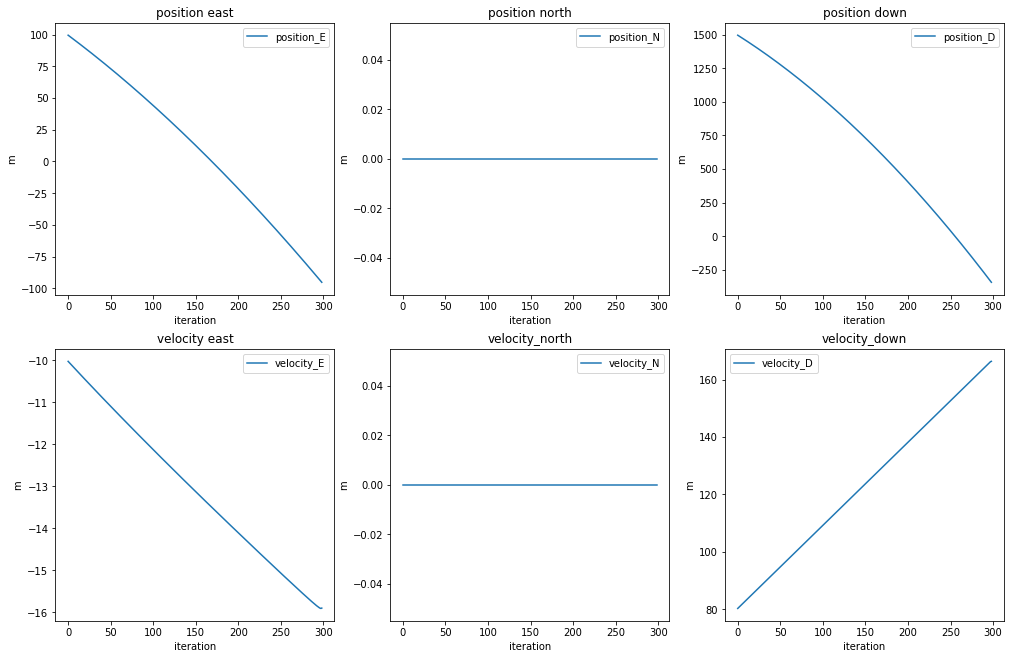

In [38]:
plt.figure(figsize=(17,11))

plt.subplot(2,3,1)
plt.plot(result["state"][0,:-1], label="position_E")
plt.title("position east")
plt.xlabel("iteration")
plt.ylabel("m")
plt.legend()

plt.subplot(2,3,2)
plt.plot(result["state"][1,:-1], label="position_N")
plt.title("position north")
plt.xlabel("iteration")
plt.ylabel("m")
plt.legend()

plt.subplot(2,3,3)
plt.plot(result["state"][2,:-1]*(-1), label="position_D")
plt.title("position down")
plt.xlabel("iteration")
plt.ylabel("m")
plt.legend()

plt.subplot(2,3,4)
plt.plot(result["state"][3,:-1], label="velocity_E")
plt.title("velocity east")
plt.xlabel("iteration")
plt.ylabel("m")
plt.legend()

plt.subplot(2,3,5)
plt.plot(result["state"][4,:-1], label="velocity_N")
plt.title("velocity_north")
plt.xlabel("iteration")
plt.ylabel("m")
plt.legend()

plt.subplot(2,3,6)
plt.plot(result["state"][5,:-1], label="velocity_D")
plt.title("velocity_down")
plt.xlabel("iteration")
plt.ylabel("m")
plt.legend()

plt.show()